In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Format the hourly load data to account for inconsistencies with how BC Hydro handles daylight savings
def fix_hourly_load(load, year):
    #Filter down to just the loads
    fixed = pd.to_numeric(load[load.columns[-1]], errors='coerce') #Rightmost column in BC Hydro hourly load spreadsheet, to_numeric converts the labels into NaN
    fixed = fixed.reset_index().drop(columns=['index'])
    fixed.columns = ['LOAD']

    #Remove NaN values (the column labels and sometimes the value for DST hour) and 0 values (sometimes the DST hour), then convert from MWh to kWh
    fixed = fixed.loc[fixed['LOAD'] > 0] * 1000
    
    #Index hourly loads by hourly timestamp
    fixed['TIME'] = pd.date_range(start=str(year)+'-01-01 00:00:00', end=str(year)+'-12-31 23:00:00', freq='h')
    fixed = fixed.set_index('TIME')

    #Return the hourly load for the entire province for a given year
    return fixed

In [3]:
#Format the hourly load data to account for inconsistencies with how BC Hydro handles daylight savings
def fix_hourly_trade(load, year):
    #This literally only happens in the 2016 data. There is a random extra column that is filled with NaN values that has no label
    if len(load.columns) == 5:
        load.drop(columns=load.columns[-1], inplace=True)

    #Filter down to just the loads
    us = pd.to_numeric(load[load.columns[-2]], errors='coerce') #Rightmost column in BC Hydro hourly load spreadsheet, to_numeric converts the labels into NaN
    us = us.reset_index().drop(columns=['index'])

    ab = pd.to_numeric(load[load.columns[-1]], errors='coerce') #Rightmost column in BC Hydro hourly load spreadsheet, to_numeric converts the labels into NaN
    ab = ab.reset_index().drop(columns=['index'])

    #Due to daylight savings inconsistencies, this column is necessary
    h = pd.to_numeric(load[load.columns[-3]], errors='coerce') #Rightmost column in BC Hydro hourly load spreadsheet, to_numeric converts the labels into NaN
    h = h.reset_index().drop(columns=['index'])

    fixed = pd.DataFrame(data={
        'HOUR': h[load.columns[-3]],
        'US': us[load.columns[-2]],
        'AB': ab[load.columns[-1]]
    })

    #Remove NaN values, then convert from MWh to kWh
    fixed = fixed.dropna() * 1000

    #Get daylight savings'd by BC Hydro
    if len(fixed) % 24 != 0:
        i = 1
        hour = fixed.loc[fixed.index == 1]['HOUR'].values[0]
        match = False
        while not match:
            i = i + 1
            if hour == fixed.loc[fixed.index == i]['HOUR'].values[0]:
                match = True
            hour = fixed.loc[fixed.index == i]['HOUR'].values[0]
        
        #Once the offending row has been found, add it to the row just above, then perform an inplace drop
        fixed.loc[fixed.index == i-1] += fixed.loc[fixed.index == i]
        fixed.drop(labels=[i], inplace=True)
    
    #Drop the hours column
    fixed = fixed.drop(columns=['HOUR'])
    
    #Index hourly loads by hourly timestamp
    fixed['TIME'] = pd.date_range(start=str(year)+'-01-01 00:00:00', end=str(year)+'-12-31 23:00:00', freq='h')
    fixed = fixed.set_index('TIME')

    #Return the hourly load for the entire province for a given year
    return fixed

In [4]:
#Set the seaborn theme
sns.set_theme()

In [5]:
#Hourly load and trade data from BC Hydro
year = 2020
hourly = fix_hourly_load(pd.read_excel('./load/BalancingAuthorityLoad' + str(year) + '.xls'), year)

#Sum for comparison later, as CEEI data only tracks load for the entire year, then convert from kW to GW for a nicer display later
bc_hydro_annual = (hourly['LOAD']).sum() / 1e6
bc_hydro_annual

62798.215

In [6]:
#Try loading in the data
ceei = pd.read_excel('./CEEI_2020.xlsx', sheet_name='Combined')
#CEEI data only goes up to 2020, use 2020 if looking at hourly loads 2020 or later
#We only need data for electricity usage from regional districts for this disaggregation step
ceei = ceei.loc[(ceei.YEAR == min(2020, year)) & (ceei.ENERGY_TYPE == 'ELEC') & (ceei.ORG_TYPE == 'Regional District')]
ceei

,YEAR,SOURCE,Data Source ID,ORG_UNIT,ORG_NAME,ORG_TYPE,ORG_PART,ENERGY_TYPE,ENERGY_UNIT,SUB_SECTOR,CATEGORY,SUB_CATEGORY,CONSUMPTION_TOTAL,CONNECTION_TOTAL,EMISSIONS (TCO2e),EMISSIONS (With imports) (TCO2e)
4,2020,BC Hydro,9080.0,1005923,Alberni-Clayoquot,Regional District,9000000,ELEC,kWh,Res,Res-Total,Res-Total-Total,211115307.840498,16826.0,2251.896617,8226.459829
14,2020,BC Hydro,9080.0,1005951,Bulkley-Nechako,Regional District,9000000,ELEC,kWh,Res,Res-Total,Res-Total-Total,222015539.533258,19403.0,2368.165755,8651.205524
29,2020,BC Hydro,9080.0,1005917,Capital,Regional District,9000000,ELEC,kWh,Res,Res-Total,Res-Total-Total,1928956589.493145,176321.0,20575.536955,75165.008437
35,2020,BC Hydro,9080.0,1005941,Cariboo,Regional District,9000000,ELEC,kWh,Res,Res-Total,Res-Total-Total,340826790.350448,33676.0,3635.485764,13280.883931
37,2020,BC Hydro,9080.0,1005945,Central Coast,Regional District,9000000,ELEC,kWh,Res,Res-Total,Res-Total-Total,18200693.612233,1463.0,194.140732,709.220361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8959,2020,City of Penticton,9210.0,1005907,Okanagan-Similkameen,Regional District,9000000,ELEC,kWh,CSMI,CSMI-Total,CSMI-Total-Total,153984552,1974.0,1642.501888,6000.26471
9084,2020,City of Summerland,9200.0,1005907,Okanagan-Similkameen,Regional District,9000000,ELEC,kWh,Res,Res-Total,Res-Total-Total,61709500,5405.0,157.97632,2404.613517
9085,2020,City of Summerland,9200.0,1005907,Okanagan-Similkameen,Regional District,9000000,ELEC,kWh,CSMI,CSMI-Total,CSMI-Total-Total,25656530,638.0,65.680717,999.749452
9162,2020,Yukon Electric (Atco),9260.0,1005957,Stikine,Regional District,9000000,ELEC,kWh,Res,Res-Total,Res-Total-Total,504247,67.0,5.378635,19.648825


In [7]:
#Calculate some sums to compare with BC_Hydro's annual aggregate (and convert kW to GW)
ceei_annual = ceei['CONSUMPTION_TOTAL'].sum() / 1e6
res_annual = ceei.loc[ceei['SUB_SECTOR'] == 'Res']['CONSUMPTION_TOTAL'].sum() / 1e6
csmi_annual = ceei.loc[ceei['SUB_SECTOR'] == 'CSMI']['CONSUMPTION_TOTAL'].sum() / 1e6

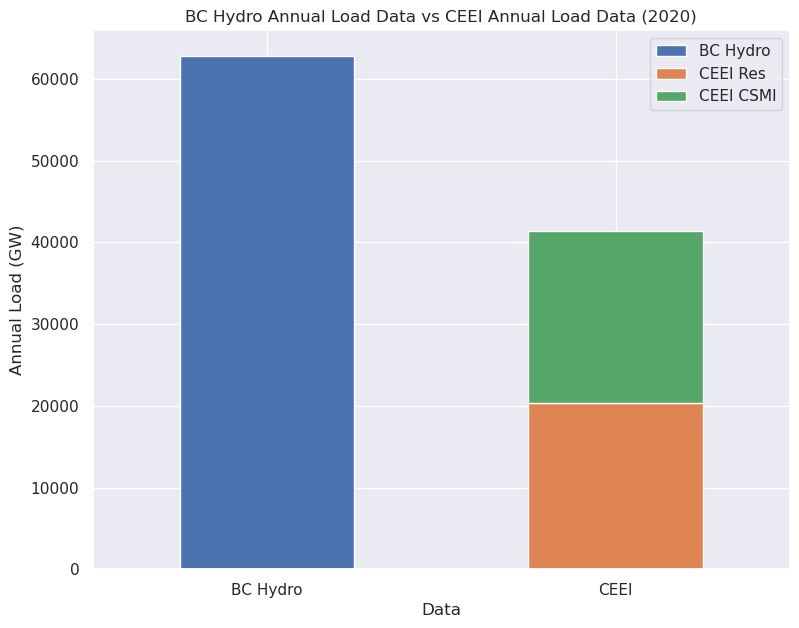

In [8]:
#Make a frame for showing Res + CSMI stacked up against BC Hydro
plt_frame = pd.DataFrame([['BC Hydro', bc_hydro_annual, 0, 0], ['CEEI', 0, res_annual, csmi_annual]], columns=['Data', 'BC Hydro', 'CEEI Res', 'CEEI CSMI'])
 
#Plot data in stack manner of bar type
plt_frame.plot(x='Data', kind='bar', stacked=True, title='BC Hydro Annual Load Data vs CEEI Annual Load Data (' + str(year) + ')', figsize=(9, 7))

#Some plot formatting
plt.xticks(rotation=0)
plt.ylabel('Annual Load (GW)')
plt.show()

In [9]:
#Grouping annual load by region
ceei_regional = ceei.groupby('ORG_NAME')['CONSUMPTION_TOTAL'].sum().sort_values() / 1e6
ceei_regional

ORG_NAME
Stikine                        6.86465
Central Coast                 30.63201
Northern Rockies             52.593526
Mount Waddington            150.006288
Powell River                183.797131
Skeena-Queen Charlotte      213.411793
Alberni-Clayoquot           354.996563
Sunshine Coast              381.274841
Kitimat-Stikine              403.86143
Bulkley-Nechako             418.841314
Kootenay Boundary           446.984203
Strathcona                  463.042742
Cariboo                     590.398454
Comox Valley                628.915814
East Kootenay               670.653102
Central Kootenay            676.403226
Squamish-Lillooet           692.893811
Columbia-Shuswap            700.550009
North Okanagan              821.950924
Fraser-Fort George          869.859845
Okanagan-Similkameen        890.832276
Cowichan Valley             921.111169
Peace River                  989.71961
Nanaimo                    1509.170374
Central Okanagan            1931.98715
Thompson-Nicola 

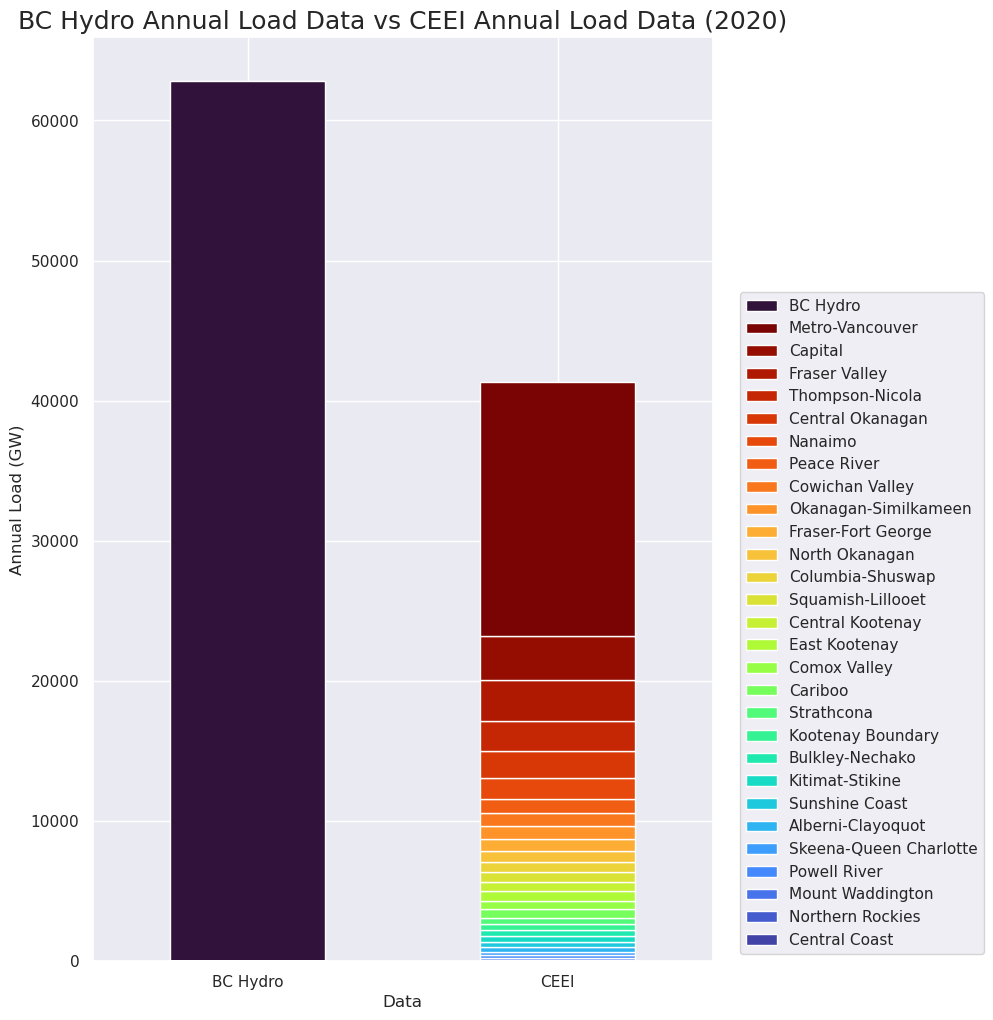

In [10]:
#Make a frame for showing Res + CSMI stacked up against BC Hydro
plt_frame = pd.DataFrame([['BC Hydro', bc_hydro_annual] + np.zeros(28).tolist(),
                          ['CEEI', 0] + ceei_regional.values.tolist()
                          ],
                         columns=['Data', 'BC Hydro'] + ceei_regional.index.tolist())
 
#Plot data in stack manner of bar type
plt_frame.plot(x='Data', kind='bar', stacked=True, figsize=(8, 12), colormap="turbo")

#Some plot formatting
plt.xticks(rotation=0)
plt.ylabel('Annual Load (GW)')
plt.title('BC Hydro Annual Load Data vs CEEI Annual Load Data (' + str(year) + ')', fontsize=18)

#Legend formatting, huge thanks to https://www.statology.org/matplotlib-legend-order/
handles, labels = plt.gca().get_legend_handles_labels()
order = [0] + np.arange(start=29, stop=1, step=-1).tolist()
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.45, 0), loc='lower right') 

plt.show()

In [11]:
#Quickly calculating relative errors between BC Hydro and CEEI for all years and displaying it in a DataFrame
ceei = pd.read_excel('./CEEI_2020.xlsx', sheet_name='Combined')
ceei = ceei.loc[(ceei.ENERGY_TYPE == 'ELEC') & (ceei.ORG_TYPE == 'Regional District')]

years = np.arange(start=2015, stop=2023)

error_frame = pd.DataFrame()

for y in years:
    hr = fix_hourly_load(pd.read_excel('./load/BalancingAuthorityLoad' + str(y) + '.xls'), y)
    no_trade_sum = hr['LOAD'].sum() / 1e6
    ceei_sum = ceei.loc[(ceei.YEAR == min(2020, y))]['CONSUMPTION_TOTAL'].sum() / 1e6

    
    rel = round(np.abs(((ceei_sum - no_trade_sum) / no_trade_sum)) * 100, 3)

    to_error_frame = pd.DataFrame(data={
        'Year': [y],
        'CEEI Annual Load (GW)': [ceei_sum],
        'BC Hydro Annual Load (GW)': [no_trade_sum],
        'Relative Error (%)': [rel],
    })

    error_frame = pd.concat([error_frame, to_error_frame])

error_frame = error_frame.set_index('Year')
error_frame

,CEEI Annual Load (GW),BC Hydro Annual Load (GW),Relative Error (%)
Year,,,
2015,39735.957147,61647.759,35.544
2016,40136.021776,62422.164,35.702
2017,41677.022526,63994.519,34.874
2018,40711.592367,63143.941,35.526
2019,40768.330897,63522.356,35.820
2020,41360.692276,62798.215,34.137
2021,41360.692276,65054.202,36.421
2022,41360.692276,65519.433,36.873
